In [1]:
import pandas as pd
import ta
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime, date
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
pd.set_option('display.max_columns', 50)
#pd.set_option('display.max_rows', 500)

In [2]:
con = sqlite3.connect('TRADES_GBPUSD_M15_COMPRADO.sqlite')
cur = con.cursor()
df = pd.read_sql_query('SELECT '
                          "   d1.time as time_in,"
                          "   d1.position_id as ticket,"
                          "   d1.type as type,"
                          "   d1.volume as volume,"
                          "   d1.symbol as symbol,"
                          "   d1.price as price_in,"
                          "   d2.time as time_out,"
                          "   d2.price as price_out,"
                          "   d1.commission+d2.commission as commission,"
                          "   d2.swap as swap,"
                          "   d2.profit as profit "
                          "FROM TRADE d1 "
                          "INNER JOIN TRADE d2 ON d1.position_id=d2.position_id "
                          "WHERE d1.entry=0 AND d2.entry=1", con)

df['time_in'] = pd.to_datetime(df['time_in'], unit='s')
df['time_out'] = pd.to_datetime(df['time_out'], unit='s')
df['profit_ajustado'] = df['profit'] + df['commission'] + df['swap']
df['ResultCum'] = np.cumsum(df['profit_ajustado'])
df['alvo'] = [1 if i > 0 else 0 for i in df['profit_ajustado']]
df

,time_in,ticket,type,volume,symbol,price_in,time_out,price_out,commission,swap,profit,profit_ajustado,ResultCum,alvo
0,2015-01-12 16:45:40,2.0,0,0.01,GBPUSD,1.51557,2015-01-12 17:37:00,1.51392,-0.08,0.0,-1.65,-1.73,-1.73,0
1,2015-01-16 12:24:40,4.0,0,0.01,GBPUSD,1.52261,2015-01-16 12:53:20,1.52061,-0.08,0.0,-2.00,-2.08,-3.81,0
2,2015-01-20 15:34:40,7.0,0,0.01,GBPUSD,1.51852,2015-01-20 18:15:00,1.51833,-0.08,0.0,-0.19,-0.27,-4.08,0
3,2015-01-27 17:33:40,9.0,0,0.01,GBPUSD,1.51907,2015-01-27 20:15:00,1.51986,-0.08,0.0,0.79,0.71,-3.37,1
4,2015-01-28 09:30:20,11.0,0,0.02,GBPUSD,1.51806,2015-01-28 09:32:40,1.51755,-0.14,0.0,-1.02,-1.16,-4.53,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,2020-10-08 09:32:40,2002.0,0,0.01,GBPUSD,1.29422,2020-10-08 11:15:40,1.29664,-0.08,0.0,2.42,2.34,-38.38,1
884,2020-10-08 12:21:20,2004.0,0,0.01,GBPUSD,1.29618,2020-10-08 12:31:40,1.29486,-0.08,0.0,-1.32,-1.40,-39.78,0
885,2020-10-09 11:00:40,2006.0,0,0.01,GBPUSD,1.29607,2020-10-09 11:09:40,1.29509,-0.08,0.0,-0.98,-1.06,-40.84,0
886,2020-10-09 17:00:40,2009.0,0,0.01,GBPUSD,1.29721,2020-10-09 17:49:40,1.29968,-0.08,0.0,2.47,2.39,-38.45,1


In [3]:
data = df[['symbol','time_in', 'profit_ajustado', 'alvo']]
#data['time_in'] = [i.replace(hour = i.hour - (i.hour % 2),minute=0, second=0) for i in data['time_in']] #H2
#data['time_in'] = [i.replace(minute=0, second=0) if i.minute < 30 else i.replace(minute= 30 , second=0) for i in df['time_in']] #H1
data['time_in'] = [i.replace(minute=0, second=0) if i.minute < 15 else i.replace(minute= i.minute - (i.minute % 15), second=0) for i in df['time_in']] #H1
data['hora'] = [i.hour for i in data['time_in']]
data.set_index('time_in', inplace = True)
data

<ipython-input-3-58a79983a5c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_in'] = [i.replace(minute=0, second=0) if i.minute < 15 else i.replace(minute= i.minute - (i.minute % 15), second=0) for i in df['time_in']] #H1
<ipython-input-3-58a79983a5c2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hora'] = [i.hour for i in data['time_in']]


,symbol,profit_ajustado,alvo,hora
time_in,,,,
2015-01-12 16:45:00,GBPUSD,-1.73,0,16
2015-01-16 12:15:00,GBPUSD,-2.08,0,12
2015-01-20 15:30:00,GBPUSD,-0.27,0,15
2015-01-27 17:30:00,GBPUSD,0.71,1,17
2015-01-28 09:30:00,GBPUSD,-1.16,0,9
...,...,...,...,...
2020-10-08 09:30:00,GBPUSD,2.34,1,9
2020-10-08 12:15:00,GBPUSD,-1.40,0,12
2020-10-09 11:00:00,GBPUSD,-1.06,0,11


In [4]:
if not mt5.initialize(path="C:\Program Files\MetaTrader 5\\terminal64.exe"):
    print("initialize() failed, error code =", mt5.last_error())
    quit()

In [78]:
date_from = datetime(2015,1,1)
rates = mt5.copy_rates_from_pos("GBPUSD", mt5.TIMEFRAME_M15, 0, 99999)
#rates = mt5.copy_rates_range("GBPUSD", mt5.TIMEFRAME_M15,date_from , datetime.now())
#rates = mt5.copy_rates_from("EURUSD", mt5.TIMEFRAME_M30, date_from, 10)

a = pd.DataFrame(rates)
a['time'] = pd.to_datetime(a['time'], unit='s')
a.set_index('time', inplace=True)
a

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2016-10-07 20:00:00,1.24583,1.24627,1.24429,1.24486,2509,11,2069745000
2016-10-07 20:15:00,1.24486,1.24580,1.24438,1.24505,1858,11,1783140000
2016-10-07 20:30:00,1.24508,1.24575,1.24475,1.24559,1387,11,1139610000
2016-10-07 20:45:00,1.24559,1.24569,1.24304,1.24326,1321,11,1157930000
2016-10-07 21:00:00,1.24326,1.24480,1.24314,1.24451,1697,11,1464550000
...,...,...,...,...,...,...,...
2020-10-15 13:30:00,1.29456,1.29592,1.29420,1.29590,1237,0,0
2020-10-15 13:45:00,1.29591,1.29604,1.29456,1.29524,1468,0,0
2020-10-15 14:00:00,1.29524,1.29628,1.29203,1.29232,1945,0,0


In [79]:
dataframe = a.join(data) # Dataframe Para análise
dataframe

,open,high,low,close,tick_volume,spread,real_volume,symbol,profit_ajustado,alvo,hora
2016-10-07 20:00:00,1.24583,1.24627,1.24429,1.24486,2509,11,2069745000,NaN,NaN,NaN,NaN
2016-10-07 20:15:00,1.24486,1.24580,1.24438,1.24505,1858,11,1783140000,NaN,NaN,NaN,NaN
2016-10-07 20:30:00,1.24508,1.24575,1.24475,1.24559,1387,11,1139610000,NaN,NaN,NaN,NaN
2016-10-07 20:45:00,1.24559,1.24569,1.24304,1.24326,1321,11,1157930000,NaN,NaN,NaN,NaN
2016-10-07 21:00:00,1.24326,1.24480,1.24314,1.24451,1697,11,1464550000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-15 13:30:00,1.29456,1.29592,1.29420,1.29590,1237,0,0,NaN,NaN,NaN,NaN
2020-10-15 13:45:00,1.29591,1.29604,1.29456,1.29524,1468,0,0,NaN,NaN,NaN,NaN
2020-10-15 14:00:00,1.29524,1.29628,1.29203,1.29232,1945,0,0,NaN,NaN,NaN,NaN
2020-10-15 14:15:00,1.29232,1.29264,1.29089,1.29183,1602,0,0,NaN,NaN,NaN,NaN


In [80]:
indicador_rsi = ta.momentum.RSIIndicator(close = dataframe['close'], n = 2, fillna = False)

dataframe['rsi'] = indicador_rsi.rsi()
dataframe.dropna(inplace = True)
dataframe

,open,high,low,close,tick_volume,spread,real_volume,symbol,profit_ajustado,alvo,hora,rsi
2016-10-19 14:15:00,1.23055,1.23079,1.22846,1.22846,1623,12,1088970000,GBPUSD,-1.41,0.0,14.0,12.898554
2016-10-24 11:45:00,1.22302,1.22379,1.22299,1.22374,1056,11,487646000,GBPUSD,1.09,1.0,11.0,74.187658
2016-10-26 12:15:00,1.22029,1.22188,1.22028,1.22089,2041,11,1343567000,GBPUSD,-0.09,0.0,12.0,63.294445
2016-10-27 14:45:00,1.22529,1.22553,1.22457,1.22459,1625,12,1233802000,GBPUSD,-1.02,0.0,14.0,10.474132
2016-11-02 09:15:00,1.22457,1.22570,1.22449,1.22519,1825,11,1367459000,GBPUSD,2.61,1.0,9.0,81.809387
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-08 09:30:00,1.29410,1.29480,1.29402,1.29452,974,0,0,GBPUSD,2.34,1.0,9.0,83.682971
2020-10-08 12:15:00,1.29582,1.29626,1.29526,1.29528,768,0,0,GBPUSD,-1.40,0.0,12.0,25.643490
2020-10-09 11:00:00,1.29583,1.29732,1.29459,1.29514,2428,0,0,GBPUSD,-1.06,0.0,11.0,21.372257
2020-10-09 17:00:00,1.29720,1.29790,1.29698,1.29759,1536,0,0,GBPUSD,2.39,1.0,17.0,86.094343


In [81]:
variaveis = ['rsi']
X = dataframe[variaveis]
y = dataframe['alvo']

dias_treino = 370

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_test, y_train, y_test = X[0:dias_treino], X[dias_treino:], y[0:dias_treino], y[dias_treino:]
random = RandomForestClassifier(random_state=42)
random = random.fit(X_train,y_train)
resultadoRandom = random.predict(X_test)
print(metrics.classification_report(resultadoRandom,y_test))

              precision    recall  f1-score   support

         0.0       0.72      0.59      0.65       204
         1.0       0.38      0.52      0.44        99

    accuracy                           0.57       303
   macro avg       0.55      0.55      0.54       303
weighted avg       0.61      0.57      0.58       303



<ipython-input-82-f2268247afa2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backdf['previsao'] = resultadoRandom
<ipython-input-82-f2268247afa2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backdf['operation'] = backdf['previsao'] * backdf['profit_ajustado']
<ipython-input-82-f2268247afa2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

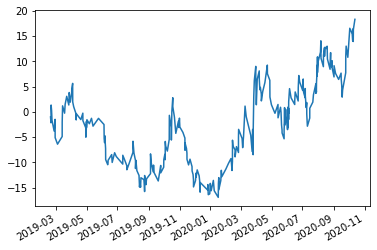

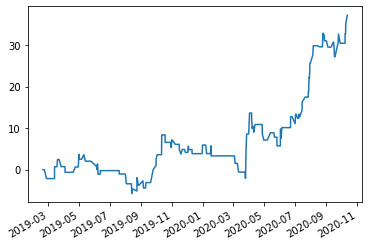

In [82]:
#Gambiarra pra saber quando devia operar

backdf = dataframe[dias_treino:]
backdf['previsao'] = resultadoRandom
backdf['operation'] = backdf['previsao'] * backdf['profit_ajustado']
backdf['ResultCum'] = np.cumsum(backdf['operation'])
backdf['ResultOriginal'] = np.cumsum(backdf['profit_ajustado'])
backdf['ResultOriginal'].plot()
plt.show()
backdf['ResultCum'].plot()

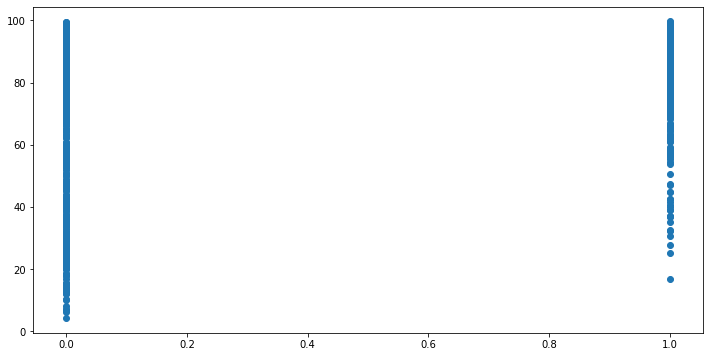

In [83]:
plt.figure(figsize=(12,6))
plt.scatter(dataframe['alvo'], dataframe['rsi'])

In [ ]:
import pickle
# salvar o modelo RandomForest no arquivo PFR_GBPUSD_H2.pkl
with open('PFR_GBPUSD_H2.pkl', 'wb') as file:
    pickle.dump(random, file)